In [1]:
# Script creates custom environment and runs within the RLlib framework

import pandas as pd
import yfinance as yf
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

import matplotlib
import matplotlib.pyplot as plt
import datetime

import os

from sklearn.preprocessing import MinMaxScaler

from ray.rllib.models.preprocessors import get_preprocessor
import ray

from datasimulator import DataSimulator

/home/zet4/.virtualenvs/rayrl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Simulating Module for Sanity Check <br>
&emsp; -- dummy data for sanity check of deep reinforcement learning algorithms and environments <br>
&emsp; &emsp; -- based on input parameters, create "good" and "bad" data <br>
&emsp; -- simulated data based on calibrated distribution function to enrich datasets <br>
&emsp; &emsp; -- 

##### Dummy data simulation <br>
Stochastic differential equation for the process is: <br>

&emsp; $\frac{dP_{t}}{P_{t}} = µdt + σdW_{t}$ <br>

Closed-form integration of the SDE: <br>

&emsp; St = $S_{0}exp(\int_{0}^{t}[\mu - \frac{1}{2}\sigma^2]ds + \int_{0}^{t}\sigma dW_{s})$

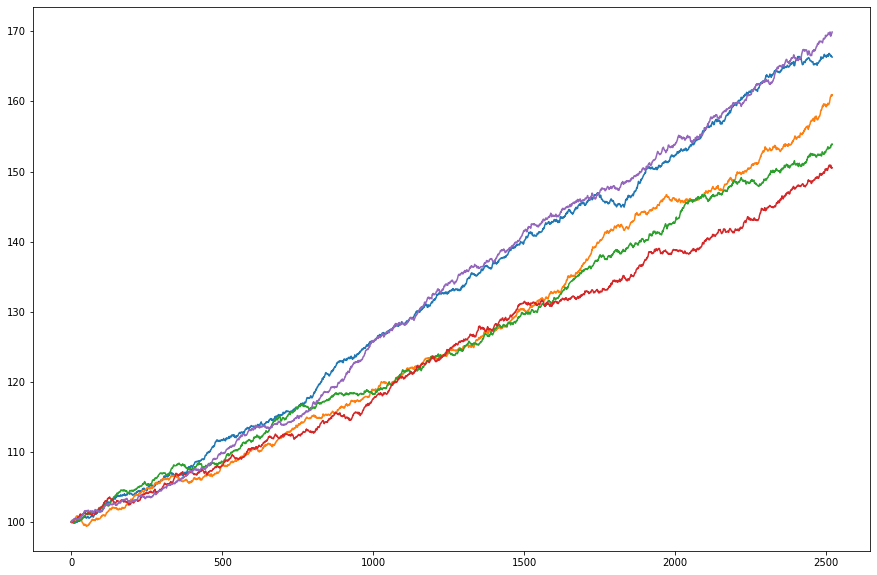

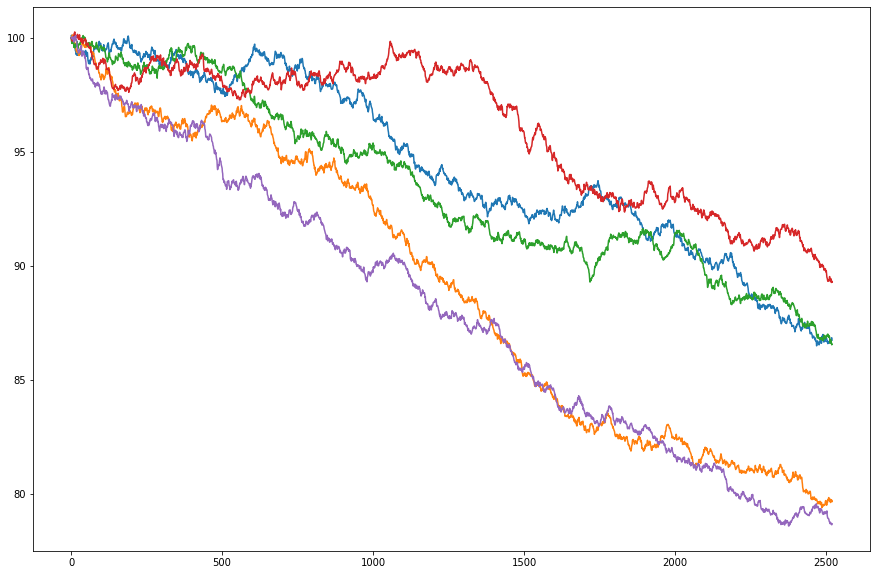

In [3]:
data = DataSimulator(mu=0.45, sigma=0.04, N=5, days=252*10)
data2 = DataSimulator(mu=-0.18, sigma=0.04, N=5, days=252*10)

In [5]:
class StockPickerEnv(gym.Env):
    def __init__(self,
                #tickers=['ES=F', 'IBM', 'VOW.DE', 'VRTX'],
                tickers = ['F', 'VRTX', 'AMZN'],
                initial_amount=100000, 
                mkt_position_thresholds=(0,2), 
                leverage_threshold=2,
                N=3,
                max_stocks=4):
        # Atributes
        self.tickers = tickers
        self.N = N # dummy stocks 'good' and 'bad'; radek is real badass
        self.df = self._get_data()
        self.initial_amount = initial_amount
        self.n_stocks = 0
        self.index = 0
        self.transactions_cost_pct = 0.0015
        self.portfolio_value = self.initial_amount
        self.done = False
        self.features_list = ['LogReturns']
        self.mkt_position_thresholds = mkt_position_thresholds
        self.leverage_threshold = leverage_threshold
        self.total_market_position = 0
        self.leverage = 1
        self.max_stocks = max_stocks
        self.action_number = len(self.tickers) + 2 * self.N if self.N > 0 else len(self.tickers) # N is for dummy stocks: 2* because stocks are 'good' and 'bad'
        
        # Acton-State space
        self.action_space = spaces.Dict({
                            "total_market_position": spaces.Box(low=0, high=2, shape=()),
                            "leverage": spaces.Box(low=1, high=2, shape=()),
                            "orders": spaces.MultiDiscrete([3]*9)
                            #"orders": spaces.MultiDiscrete([3]*self.action_number)
                            })
        '''
        self.observation_space = spaces.Dict({
                                #"features": spaces.Box(low=-np.inf, high=np.inf, shape=(len(self.df.Symbol.unique()), )),  #len(self.df.columns)-2
                                "features": spaces.Box(low=0, high=1, shape=(8,)),
                                "n_stocks":spaces.Discrete(15)
                        })
        '''
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(9,), dtype=np.float32)
        
        # Memory Buffer
        self.reward_memory = [0] 
        self.actions_memory = len(self.df.Symbol.unique()) * [0] # no actions at the beginning
        self.date_memory =  [self.df.Date.unique()[0]] # first date where the action and reward is nothing       

    def step(self, action):
        #print(f'A C T I O N {action["orders"]}')
        n_longs = len([ x for x in action['orders'] if x > 0 ])
        n_shorts = len([ x for x in action['orders'] if x < 0 ])
        self.n_stocks = len([ x for x in action['orders'] if x != 0 ]) # beacause of gym.spaces.Discrete()
        
        self.total_market_position = action['total_market_position']
        self.leverage = action['leverage']
        
        # Load next state (data for next day)
        self.index += 1
        previous_day_data = self.df[self.df.Date==self.df.Date.unique()[self.index-1]]
        current_day_data = self.df[self.df.Date==self.df.Date.unique()[self.index]]
        features_data = current_day_data[self.features_list].values.flatten()
        
        '''
        self.state = { "features": features_data,
                        "n_stocks": self.n_stocks
                    }
        self.state = self.flatten_obs()
        '''
        self.state = np.float32(features_data)
        #print(f'state from step: {self.state}')

        # incoming parameter "action" brings i.a. list of orders (as actuall picks)
        picks_ = []
        actionMapper = {
            0:0,
            1:1,
            2:-1
        }
        [ picks_.append(actionMapper[pick]) for pick in action['orders'] ]

        ### Capital allocation ###
        # Array with allocations -- portfolio items values at the start of the trading period
        long_weight, short_weight = self._get_weights()
        nav_per_long = long_weight * self.portfolio_value
        nav_per_short = short_weight * self.portfolio_value
        allocations = np.array(picks_)
        allocations = np.where(allocations > 0, allocations*nav_per_long, allocations)
        allocations = np.where(allocations < 0, allocations*nav_per_short, allocations)
        # Calculation of results for specific time period -- return rate, profit, new portfolio values
        change_rate = current_day_data.Close.values / previous_day_data.Close.values
        _rewards = change_rate * allocations - allocations # aka profit for each asset
        reward = np.sum(_rewards)
        
        self.reward_memory.append(reward)
        #profit_rate = reward / self.portfolio_value
        self.portfolio_value += reward

        self.done = bool(self.index >= len(self.df.Date.unique()) - 2) # explanation: e.g. length is 100 => 100 - 1 to receive correct index value and 99 - 1 to switch done = True before the last step (else in the next step the index is out of range). In other words, action is taken at the penultimate step, ultimate step i terminal
        
        if self.done:
            daily_returns = pd.DataFrame(self.reward_memory)
            daily_returns.columns = ["Daily_return"]
            #plt.plot(daily_returns.Daily_return.cumsum(), 'r')
            #plt.savefig('results*cumulative.png')
            #plt.close()

            #plt.plot(self.reward_memory, 'r')
            #plt.savefig('results/portfolio_value.png')
            #plt.close()

            print("====================================")
            print(f"end_total_asset: {self.portfolio_value}")

            #print(f'reward memory: {self.reward_memory}')
            if daily_returns['Daily_return'].std() != 0:
                sharpe = (252**0.5) * daily_returns['Daily_return'].mean() / daily_returns['Daily_return'].std()
                print(f'sharpe: {sharpe}')

        return self.state, self.reward_memory[-1], self.done, {'Terminal step': self.done}
    
    def _get_data(self, start='2010-01-01'):
        '''
        Price data download. 
        If self.sanity_check is True, the method simulates "good" and "bad" stocks and add them to the outcoming dataframe.
        Simulated data serves as a sanity check for data mining and optimization algorithms (one can intuitively see whether the algos work).
        '''    
        if self.tickers != []:

            #df = yf.download(self.tickers, start=start)
            df = yf.download(['F', 'VRTX', 'AMZN'])
            df = df.Close
            df = df.dropna().reset_index()
            df['Date'] = df['Date'].astype(str)
            #df = df.melt(id_vars=['Date'], var_name='Symbol', value_name='Close')

        if self.N > 0:
            good_data = DataSimulator(mu=0.18, sigma=0.04, N=self.N, days=len(df.Date.unique())-1, name_prefix='good_stock', plot=False)
            good_df = pd.DataFrame(data=good_data.S, columns=good_data.names)
            good_df['Date'] = df.Date.unique()
            #good_df = good_df.melt(id_vars=['Date'], var_name='Symbol', value_name='Close')
            #print(f'Good data: {good_df}')
            bad_data = DataSimulator(mu=-0.02, sigma=0.35, N=self.N, days=len(df.Date.unique())-1, name_prefix='bad_stock', plot=False)
            bad_df = pd.DataFrame(data=bad_data.S, columns=bad_data.names)
            bad_df['Date'] = df.Date.unique()
            #bad_df = bad_df.melt(id_vars=['Date'], var_name='Symbol', value_name='Close')
            #print(f'Bad data: {bad_df}')
            df = pd.concat(objs=[df, good_df, bad_df], axis='columns')
            df = df.loc[:, ~df.columns.duplicated()].copy() # Date column is duplicated
            df = df.reset_index(drop=True) # duplicity in index

        closePrices = df.drop(['Date'], axis=1) #keep only numbers for returns calculation
        logReturns = np.log(closePrices / closePrices.shift(1))

        scaler = MinMaxScaler()
        scaler.fit(logReturns.T)
        scaledReturns = scaler.transform(logReturns.T).T # cross-sectional scaling
        #print(logReturns.columns)
        scaledReturns = pd.DataFrame(scaledReturns, columns=logReturns.columns)
        scaledReturns['Date'] = df.Date.unique()

        df = df.melt(id_vars=['Date'], var_name='Symbol', value_name='Close')
        scaledReturns = scaledReturns.melt(id_vars=['Date'], var_name='Symbol', value_name='LogReturns')

        df = pd.concat(objs=[df, scaledReturns], axis='columns')
        df = df.loc[:, ~df.columns.duplicated()].copy() # drop duplicate columns
        #print(df[df.Date==df.Date.unique()[-1]])        

        return df
    
    def _get_weights(self):
        '''
        The method returns weight number for both long and short position. 
        There is an assumption that all longs (shorts) are equally weighted (warning: simultaneously longs != shorts).
        
        Relationship between 'leverage' and 'market exposition' :
        ---------------------------------------------------------
        leverage = |longs| + |shorts|
        market_exposition = longs + shorts

        One can infer 'long' and 'short' position to keep both requirements.
        '''
        if self.total_market_position < self.mkt_position_thresholds[0] or self.total_market_position > self.mkt_position_thresholds[1]:
            raise ValueError(f"Market position exceeds thresholds: {self.total_market_position} is out of the bounds {self.mkt_position_thresholds}")
        elif self.leverage < 1 or self.leverage > self.leverage_threshold:
            raise ValueError(f"Financial leverage: {self.leverage} is out of the bounds: 1, {self.leverage_threshold}")
        
        long = (self.leverage + self.total_market_position) / 2
        short = self.total_market_position - long
        long_weight = long / (self.n_stocks/2) # long share divided by number of stocks on long side (long/(n_stock/2)) 
        short_weight = short / (self.n_stocks/2) # the same but for the short side

        return long_weight, short_weight               

    def reset(self):
        #print(f'sanity check mode {self.N}')

        self.index = 1
        #print(f'index from reset {self.index}')
        self.done = False
        self.n_stocks = 0
        self.portfolio_value = self.initial_amount
        self.total_market_position = 0
        self.leverage = 0

        self.reward_memory = [0]
        self.actions_memory = len(self.df.Symbol.unique()) * [0]
        self.date_memory = [self.df.Date.unique()[0]]

        # Initial state
        features_data = self.df[self.df.Date==self.df.Date.unique()[self.index]][self.features_list].values.flatten()
        #print(features_data.shape)
        '''
        self.state = { "features": features_data,
                        "n_stocks": self.n_stocks
        }

        self.state = self._flatten_obs()
        '''
        self.state = np.float32(features_data)

        #self.state = self.flatten_obs()
        #print(f'state from reset: {self.state.shape}')
        #print(f'obs space from reset {self.observation_space}')
        #print(f'dtype from reset: {self.state.dtype}')
        return self.state

    def flatten_obs(self):
        return (get_preprocessor(self.observation_space)(self.observation_space)).transform(self.state)

In [6]:
env = StockPickerEnv()
env.df

[*********************100%***********************]  3 of 3 completed


/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Date       Symbol      Close  LogReturns
0      1997-05-15         AMZN   0.097917         NaN
1      1997-05-16         AMZN   0.086458    0.000000
2      1997-05-19         AMZN   0.085417    0.000000
3      1997-05-20         AMZN   0.081771    0.000000
4      1997-05-21         AMZN   0.071354    0.000000
...           ...          ...        ...         ...
57055  2022-07-19  bad_stock_3  81.529305    0.182032
57056  2022-07-20  bad_stock_3  81.131708    0.179816
57057  2022-07-21  bad_stock_3  81.512878    0.445447
57058  2022-07-22  bad_stock_3  81.530552    0.839553
57059  2022-07-25  bad_stock_3  81.825539    0.713433

[57060 rows x 4 columns]

In [7]:
#env.df[env.df.Date==env.df.Date.unique()[1]][env.features_list]
env.reset()

array([0.        , 0.9468174 , 0.9161661 , 0.97877127, 0.9794807 ,
       0.974484  , 0.94185925, 1.        , 0.98938084], dtype=float32)

In [1]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print
### main.py -- part 1 ###
import ray

ray.init(
            _memory=52428800, 
            object_store_memory=78643200, 
            num_cpus=1, num_gpus=0, 
            local_mode=True, 
            ignore_reinit_error=True
        )

config = {
    #'env': StockPickerEnv, # not registred so use class name
    'env_config': None,
    'num_gpus': int(os.environ.get("RLLIB_NUMGPUS", "0")),
    'model': {'max_seq_len': 128},
    'num_workers': 1, # no parallelism
    'framework': 'tf2',
}
ppo_config = DEFAULT_CONFIG.copy()
ppo_config.update(config)
ppo_config['num_workers'] = 1
ppo_config['train_batch_size'] = 128
ppo_config['num_sgd_iter'] = 10
ppo_config['framework'] = 'tf2'
ppo_config['eager_tracing'] = True
ppo_config['soft_horizon'] = True
ppo_config['disable_env_checking'] = True
ppo_config['_disable_preprocessor_api'] = True
ppo_config['horizon'] = 2000
ppo_config['ignore_worker_failures'] = True
ppo_config['entropy_coeff'] = 0.5
ppo_config['entropy_coeff']

0.5

In [2]:
ppo_config['vf_clip_param'] = 10000
ppo_config['vf_clip_param']

10000

In [3]:
ppo_config

{'num_workers': 1,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 5e-05,
 'train_batch_size': 128,
 'model': {'max_seq_len': 128},
 'optimizer': {},
 'horizon': 2000,
 'soft_horizon': True,
 'no_done_at_end': False,
 'env': None,
 'observation_space': None,
 'action_space': None,
 'env_config': None,
 'remote_worker_envs': False,
 'remote_env_batch_wait_ms': 0,
 'env_task_fn': None,
 'render_env': False,
 'record_env': False,
 'clip_rewards': None,
 'normalize_actions': True,
 'clip_actions': False,
 'preprocessor_pref': 'deepmind',
 'log_level': 'WARN',
 'callbacks': ray.rllib.agents.callbacks.DefaultCallbacks,
 'ignore_worker_failures': True,
 'recreate_failed_workers': False,
 'log_sys_usage': True,
 'fake_sampler': False,
 'framework': 'tf2',
 'eager_tracing': True,
 'eager_max_retraces': 20,
 'explore': True,
 'exploration_config': {'type': 'StochasticSampling'},
 'evaluation_in

: 

In [9]:
# Remote exercise
import time

from sklearn.ensemble import RandomForestClassifier


@ray.remote

class MessageActor:
    def __init__(self) -> list:
        self.messages = []

    def add_message(self, message):
        self.messages.append(message)

    def get_and_clear_messages(self):
        messages = self.messages
        self.messages = []
        return messages

    # Define a remote function which loops around and pushes
    # messages to the actor
@ray.remote
def worker(message_actor, j):
    for i in range(100):
        time.sleep(1)
        message_actor.add_message.remote(f"Mesage {i} from worker {j}")

# Create a message actor
message_actor = MessageActor.remote()

# Start 3 tasks that push messages to the actor
[ worker.remote(message_actor, j) for j in range(3) ]

# Periodically get the messages and print them
for _ in range(100):
    new_messages = ray.get(message_actor.get_and_clear_messages.remote())
    print("New messages: ", new_messages)
    time.sleep(1)

# This scripts print something like the following:
# New messages: []
# New messages: ['Message 0 from worker 1.', 'Message 0 from worker 0.']
# New messages: ['Message 0 from worker 2.', 'Message 1 from worker 1.', 'Message 1 from worker 0.', 'Message 1 from worker 2.']
# New messages: ['Message 2 from worker 1.', 'Message 2 from worker 0.', 'Message 2 from worker 2.']
# New messages: ['Message 3 from worker 2.', 'Message 3 from worker 1.', 'Message 3 from worker 0.']
# New messages: ['Message 4 from worker 2.', 'Message 4 from worker 0.', 'Message 4 from worker 1.']
# New messages: ['Message 5 from worker 2.', 'Message 5 from worker 0.', 'Message 5 from worker 1.']

2022-07-25 19:20:41,244	WARNING worker.py:525 -- `ray.get_gpu_ids()` will always return the empty list when called from the driver. This is because Ray does not manage GPU allocations to the driver process.
:actor_name:MessageActor
:task_name:worker


:actor_name:MessageActor
:task_name:worker
:task_name:worker


:task_name:worker


:task_name:worker


:task_name:worker


New messages:  ['Mesage 0 from worker 0', 'Mesage 1 from worker 0', 'Mesage 2 from worker 0', 'Mesage 3 from worker 0', 'Mesage 4 from worker 0', 'Mesage 5 from worker 0', 'Mesage 6 from worker 0', 'Mesage 7 from worker 0', 'Mesage 8 from worker 0', 'Mesage 9 from worker 0', 'Mesage 10 from worker 0', 'Mesage 11 from worker 0', 'Mesage 12 from worker 0', 'Mesage 13 from worker 0', 'Mesage 14 from worker 0', 'Mesage 15 from worker 0', 'Mesage 16 from worker 0', 'Mesage 17 from worker 0', 'Mesage 18 from worker 0', 'Mesage 19 from worker 0', 'Mesage 20 from worker 0', 'Mesage 21 from worker 0', 'Mesage 22 from worker 0', 'Mesage 23 from worker 0', 'Mesage 24 from worker 0', 'Mesage 25 from worker 0', 'Mesage 26 from worker 0', 'Mesage 27 from worker 0', 'Mesage 28 from worker 0', 'Mesage 29 from worker 0', 'Mesage 30 from worker 0', 'Mesage 31 from worker 0', 'Mesage 32 from worker 0', 'Mesage 33 from worker 0', 'Mesage 34 from worker 0', 'Mesage 35 from worker 0', 'Mesage 36 from worker

In [10]:
trainer = PPOTrainer(config=config, env=StockPickerEnv)
for i in range(100):
    result = trainer.train()
    print(pretty_print(result))

    if i % 5 == 0:
        checkpoint = trainer.save()
        print(f'checkpoint save at {checkpoint}')

E0725 19:27:23.076603703 3726079 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
2022-07-25 19:27:24,115	INFO trainer.py:2321 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set eager_tracing=True  in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2022-07-25 19:27:24,117	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
:actor_name:RolloutWorker


:actor_name:RolloutWorker
[*********************100%***********************]  3 of 3 completed


/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:464: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:465: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
2022-07-25 19:27:25,016	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-07-25 19:27:25,316	WARNING util.py:65 -- Install gputil for GPU system monitoring.
2022-07-25 19:29:02,798	WARNING deprecation.py:46 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
2022-07-25 19:29:02,799	WARNING deprecation.py:46 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start

agent_timesteps_total: 4000
counters:
  num_agent_steps_sampled: 4000
  num_agent_steps_trained: 4000
  num_env_steps_sampled: 4000
  num_env_steps_trained: 4000
custom_metrics: {}
date: 2022-07-25_19-29-59
done: false
episode_len_mean: .nan
episode_media: {}
episode_reward_max: .nan
episode_reward_mean: .nan
episode_reward_min: .nan
episodes_this_iter: 0
episodes_total: 0
experiment_id: 1f4acd70e3d94ce381b1703d814193db
hostname: dufek-XPS-13
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 12.680520057678223
        entropy_coeff: 0.0
        kl: 0.01437830924987793
        policy_loss: -0.019844362512230873
        total_loss: 9.983030319213867
        vf_explained_var: -4.71870098550653e-09
        vf_loss: 10.0
      num_agent_steps_trained: 125.0
  num_agent_steps_sampled: 4000
  num_agent_steps_trained: 4000
  num_env_steps_sampled: 4000
  num_env_ste

/tmp/ipykernel_3687860/1142011042.py:190: RuntimeWarning: divide by zero encountered in double_scalars
  long_weight = long / (self.n_stocks/2) # long share divided by number of stocks on long side (long/(n_stock/2))
/tmp/ipykernel_3687860/1142011042.py:191: RuntimeWarning: divide by zero encountered in double_scalars
  short_weight = short / (self.n_stocks/2) # the same but for the short side
/tmp/ipykernel_3687860/1142011042.py:88: RuntimeWarning: invalid value encountered in multiply
  allocations = np.where(allocations > 0, allocations*nav_per_long, allocations)
/tmp/ipykernel_3687860/1142011042.py:89: RuntimeWarning: invalid value encountered in multiply
  allocations = np.where(allocations < 0, allocations*nav_per_short, allocations)


agent_timesteps_total: 40000
counters:
  num_agent_steps_sampled: 40000
  num_agent_steps_trained: 40000
  num_env_steps_sampled: 40000
  num_env_steps_trained: 40000
custom_metrics: {}
date: 2022-07-25_19-54-58
done: false
episode_len_mean: 6337.0
episode_media: {}
episode_reward_max: 6897950.8061084235
episode_reward_mean: 2463227.943833182
episode_reward_min: 393650.418435668
episodes_this_iter: 1
episodes_total: 6
experiment_id: 1f4acd70e3d94ce381b1703d814193db
hostname: dufek-XPS-13
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 12.547104835510254
        entropy_coeff: 0.0
        kl: 0.022761143743991852
        policy_loss: -0.034273043274879456
        total_loss: 9.9702787399292
        vf_explained_var: -3.414849514271623e-09
        vf_loss: 10.0
      num_agent_steps_trained: 125.0
  num_agent_steps_sampled: 40000
  num_agent_steps_trained: 4

In [135]:
env.df[['Date', 'Close', 'Symbol']][env.df.Date==env.df.Date.unique()[3]]

Date       Close        Symbol
3      2010-01-06    6.612500          AMZN
3162   2010-01-06   11.370000             F
6321   2010-01-06   42.029999          VRTX
9480   2010-01-06  100.061207  good_stock_1
12639  2010-01-06  100.084276  good_stock_2
15798  2010-01-06  100.049321  good_stock_3
18957  2010-01-06  100.058383   bad_stock_1
22116  2010-01-06   98.716490   bad_stock_2
25275  2010-01-06  101.400669   bad_stock_3

In [118]:
action = env.action_space.sample()
print(f'step: {env.index}')
env.step(action)
env.reset()

step: 0
state from step: [0.00309381 0.88245981 1.         0.14437875 0.08979389 0.15746266
 0.         0.02658638 0.013961  ]
state from reset: [0.00309381 0.88245981 1.         0.14437875 0.08979389 0.15746266
 0.         0.02658638 0.013961  ]


array([0.00309381, 0.88245981, 1.        , 0.14437875, 0.08979389,
       0.15746266, 0.        , 0.02658638, 0.013961  ])

Box([0. 0. 0. 0. 0. 0. 0. 0. 0.], [1. 1. 1. 1. 1. 1. 1. 1. 1.], (9,), float32)

In [52]:
env.observation_space

Dict(features:Box([0. 0. 0. 0. 0. 0. 0. 0.], [1. 1. 1. 1. 1. 1. 1. 1.], (8,), float32), n_stocks:Discrete(15))

In [86]:
env.df.LogReturns[env.df.Date==env.df.Date.unique()[-1]].shape

(8,)

In [103]:
### main.py -- part 1 ###
import ray

ray.init(
            _memory=52428800, 
            object_store_memory=78643200, 
            num_cpus=1, num_gpus=1, 
            local_mode=True, 
            ignore_reinit_error=True
        )

2022-07-21 09:39:39,254	INFO worker.py:963 -- Calling ray.init() again after it has already been called.


RayContext(dashboard_url='', python_version='3.8.10', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '192.168.70.28', 'raylet_ip_address': '192.168.70.28', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-20_15-21-42_777485_313235/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-20_15-21-42_777485_313235/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-07-20_15-21-42_777485_313235', 'metrics_export_port': 47685, 'gcs_address': '192.168.70.28:58803', 'address': '192.168.70.28:58803', 'node_id': '2961dd2174d7f0922881d6a25e9a45fd93e0c3f4c2b68c72ae356724'})

In [104]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG

In [105]:
config = {
    'env': StockPickerEnv, # not registred so use class name
    'env_config': None,
    'num_gpus': int(os.environ.get("RLLIB_NUMGPUS", "0")),
    'model': {'max_seq_len': 128},
    'num_workers': 1, # no parallelism
    'framework': 'tf2',
}
ppo_config = DEFAULT_CONFIG.copy()
ppo_config.update(config)
ppo_config['num_workers'] = 1
ppo_config['train_batch_size'] = 128
ppo_config['num_sgd_iter'] = 10
ppo_config['framework'] = 'tf2'
ppo_config['eager_tracing'] = True
ppo_config['soft_horizon'] = True
ppo_config['disable_env_checking'] = True
ppo_config['_disable_preprocessor_api'] = True
ppo_config['horizon'] = 2000
ppo_config['ignore_worker_failures'] = True
ppo_config['entropy_coeff'] = 0.5
ppo_config['entropy_coeff']

0.5

In [1]:
#env = StockPickerEnv()
agent = PPOTrainer(config=ppo_config, env=StockPickerEnv)
agent.train()

NameError: name 'PPOTrainer' is not defined

In [2]:
### main.py -- part 2 ###
iterations = int(1e3)
training = True

def check_denied_action(action):
    '''Return True for denied and undesired actions'''
    return bool(
        len([ x for x in action['orders'] if x != 0 ]) == 0 or # at minimum one long and one short
        len([ x for x in action['orders'] if x == 1 ]) != len([ x for x in action['orders'] if x == 2 ]) or # number of longs must be same as shorts
        len([ x for x in action['orders'] if x != 0 ]) > env.max_stocks # long and short positions are not allowed to exceed maximum number of stocks
    )

if __name__=='__main__':
    env = StockPickerEnv()
    #print(f'Action space: {env.action_space}')
    agent = PPOTrainer(config=ppo_config, env=StockPickerEnv)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    step = 0
    iteration = 0

    if training:
        for iteration in range(iterations):
            result = agent.train()
            print(_, result['episode_reward_mean'])

    else:
        for iteration in range(iterations):
            done = False
            print(' -- main')
            obs = env.reset()
            cumulative_reward = 0
            steps, cumulative_rewards = [], []
            while not done:
                step += 1
                
                if training:
                    results = agent.train()
                    print(f'Iter: {step}, reward: {results["episode_reward_mean"]}')

                else:
                    action = agent.compute_single_action(obs)
                    while check_denied_action(action=action):
                        action = agent.compute_single_action(obs)
                        #check_denied_action(action)
                        
                    obs, reward, done, info = env.step(action)
                    
                    ax.plot(steps, cumulative_rewards, color='b')
                    fig.canvas.draw()
                    fig.show()

                    cumulative_reward += reward
                    cumulative_rewards.append(cumulative_reward)
                    steps.append(step)

                    if step % 100 == 0:
                        print(f'Step: {step}')
                        print(f'...choosen action: {action["orders"]} for stocks: {env.df.Symbol.unique().tolist()}')
                        print(f'received reward: {reward}')

                        print('*****************************************')
                        print(f'ITERATION NUMBER: {step}')
                        print(f'CUMULATIVE REWARD: {cumulative_reward}')
                        print('*****************************************')

                    plt.pause(0.01)

NameError: name 'StockPickerEnv' is not defined

In [87]:
env.reset()

state from reset: [0.86610015 1.         0.         0.00331589 0.00221735 0.16356052
 0.04970016 0.18380741]


array([0.86610015, 1.        , 0.        , 0.00331589, 0.00221735,
       0.16356052, 0.04970016, 0.18380741])

In [12]:
env.action_space

Dict(leverage:Box(1.0, 2.0, (), float32), orders:MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), total_market_position:Box(0.0, 2.0, (), float32))

In [51]:
from gym import spaces

def _get_weights(total_market_exposition, leverage, n_stocks, market_expo_thresholds=(0,2), leverage_threshold=2) -> tuple:

    if total_market_exposition < market_expo_thresholds[0] or total_market_exposition > market_expo_thresholds[1]:
        raise ValueError(f'Market exposition exceeds thresholds: {total_market_exposition} is out of bounds {market_expo_thresholds}')
    elif leverage < 1 or leverage > leverage_threshold:
        raise ValueError(f'Financial leverage: {leverage} is out of the bounds: 1, {leverage_threshold}')

    long = (leverage + total_market_exposition) / 2
    short = total_market_exposition - long
    print(long, short)
    long_weights = [ long / (n_stocks/2) ] * int(n_stocks/2) # long share divided by number of stocks on long side (long/(n_stock/2)) multiplied to receive an array of the long weights
    short_weights = [ short / (n_stocks/2)] * int(n_stocks/2) # the same but for the short side
    print(long_weights)
    print(short_weights)

    return long_weights, short_weights

# Sample Step
#stocks = ['AAPL', 'MSFT', 'AMZN', 'F', 'FB', "SBX", "OXY", "VRTX", "MCB", "BA"]
stocks = df.Symbol.unique().tolist()
stock_dim = len(stocks)
max_stocks = 4 # constraint of number of stocks on the one side (long or short, number of both side is equal)

done = False

while not done:

    actions = spaces.Dict({"total_market_position": spaces.Box(low=0, high=2, shape=(1,)),
                        "leverage": spaces.Box(low=1, high=2, shape=(1,)),
                        "orders": spaces.MultiDiscrete([3]*len(stocks))})    
    
    sample_actions = actions.sample()

    longs = []
    shorts = []

    mapper = {
        0:0,
        1:1,
        2:-1
    }

    picks = []
    [ picks.append(mapper[action]) for action in sample_actions["orders"] ]
    print(picks)
    total_market_position = sample_actions["total_market_position"][0]
    leverage = sample_actions["leverage"][0]
    n_stocks = len([ x for x in picks if x != 0])
    #print(f'Number of stocks: {n_stocks}')
    n_longs = len([ longs.append(x) for x in picks if x > 0 ])
    n_shorts = len([ shorts.append(x) for x in picks if x < 0 ])

    longs_weights, short_weights = _get_weights(total_market_position, leverage, n_stocks)

    done = bool(
        n_shorts == n_longs
        and n_shorts > 1 
        and n_shorts < max_stocks 
        and leverage > total_market_position)

    print(done)

print(f'Number of stocks: {n_stocks}')
print(picks)
print(f'Long Weights: {longs_weights}, Short Weights: {short_weights}')
print(f'Market Position: {total_market_position}')
print(f'Leverage: {leverage}')

[0, -1, 0, 0]
1.2693021297454834 0.20865345001220703
[]
[]
False
[-1, -1, 0, -1]
1.3778780698776245 -0.4790145754814148
[0.9185853799184164]
[-0.3193430503209432]
False
[0, 0, 1, 0]
1.3178260326385498 -0.04401206970214844
[]
[]
False
[-1, -1, -1, -1]
0.8285077810287476 -0.27753907442092896
[0.4142538905143738, 0.4142538905143738]
[-0.13876953721046448, -0.13876953721046448]
False
[-1, 1, 1, 1]
1.2470122575759888 -0.26147013902664185
[0.6235061287879944, 0.6235061287879944]
[-0.13073506951332092, -0.13073506951332092]
False
[1, 1, 0, 0]
0.943239688873291 -0.3192165493965149
[0.943239688873291]
[-0.3192165493965149]
False
[1, 0, 0, -1]
1.4845589399337769 -0.46771037578582764
[1.4845589399337769]
[-0.46771037578582764]
False
[0, 1, -1, -1]
1.022315263748169 -0.517998456954956
[0.6815435091654459]
[-0.3453323046366374]
False
[0, 1, 1, 1]
0.9743173718452454 -0.09319812059402466
[0.649544914563497]
[-0.06213208039601644]
False
[1, 1, -1, 1]
0.7154833078384399 -0.6576799750328064
[0.357741653

In [63]:
current_day_data = df[df.Date==df.Date.unique()[1]]
previous_day_data = df[df.Date==df.Date.unique()[0]]

portfolio_value = 1e5
nav_per_long = longs_weights[0] * portfolio_value
nav_per_short = abs(short_weights[0]) * portfolio_value
nav_per_long, nav_per_short

portfolio_value = 1e5
nav_per_long = longs_weights[0] * portfolio_value
nav_per_short = abs(short_weights[0]) * portfolio_value
nav_per_long, nav_per_short

import numpy as np
allocations = np.array(picks)
allocations = np.where(allocations > 0, allocations*nav_per_long, allocations)
allocations = np.where(allocations < 0, allocations*nav_per_short, allocations)
print(allocations)

[-9058.1536293  73385.87641716 73385.87641716 -9058.1536293 ]


In [93]:
reward_memory = []

change_rate = current_day_data.Close.values / previous_day_data.Close.values
profits_detail = change_rate*allocations - allocations
print(profits_detail)
profit = np.sum(change_rate*allocations - allocations)
print(profit)
reward_memory.append(profit)
print(reward_memory[-1]) # check last value as "portfolio_value_old"
profit_rate = profit / portfolio_value
print(profit_rate)
portfolio_value += profit
portfolio_value


[651.5129174  467.08477147 361.5991646  -52.26862937]
1427.9282240930588
1427.9282240930588
0.014078254866235852


102855.85644818612

In [11]:
# Import the RL algorithm (Trainer) we would like to use.
from ray.rllib.agents.ppo import PPOTrainer

# Configure the algorithm.
config = {
    # Environment (RLlib understands openAI gym registered strings).
    "env": "Taxi-v3",
    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 2,
    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    "model": {
        "fcnet_hiddens": [64, 64],
        "fcnet_activation": "relu",
    },
    # Set up a separate evaluation worker set for the
    # `trainer.evaluate()` call after training (see below).
    "evaluation_num_workers": 1,
    # Only for evaluation runs, render the env.
    "evaluation_config": {
        "render_env": True,
    },
}

# Create our RLlib Trainer.
trainer = PPOTrainer(config=config)

2022-07-19 13:11:37,244	WARNING trainer.py:2503 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
(RolloutWorker pid=166913) 2022-07-19 13:11:43,033	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=166915) 2022-07-19 13:11:43,033	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set u

In [14]:
for _ in range(50):
    print(trainer.train())

trainer.evaluate()

{'episode_reward_max': -309.0, 'episode_reward_min': -983.0, 'episode_reward_mean': -639.7875, 'episode_len_mean': 198.975, 'episode_media': {}, 'episodes_this_iter': 20, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-902.0, -785.0, -839.0, -659.0, -857.0, -893.0, -695.0, -785.0, -983.0, -731.0, -794.0, -561.0, -722.0, -821.0, -839.0, -686.0, -731.0, -857.0, -803.0, -830.0, -659.0, -614.0, -578.0, -731.0, -821.0, -650.0, -668.0, -641.0, -713.0, -767.0, -605.0, -551.0, -803.0, -695.0, -668.0, -659.0, -677.0, -641.0, -830.0, -659.0, -605.0, -542.0, -533.0, -560.0, -632.0, -596.0, -551.0, -542.0, -659.0, -596.0, -605.0, -542.0, -533.0, -704.0, -309.0, -641.0, -659.0, -596.0, -560.0, -497.0, -452.0, -587.0, -479.0, -533.0, -560.0, -461.0, -497.0, -524.0, -470.0, -614.0, -605.0, -479.0, -461.0, -416.0, -533.0, -659.0, -515.0, -515.0, -470.0, -488.0], 'episode_lengths': [200, 200, 200, 200, 200, 200, 200, 2

{'evaluation': {'episode_reward_max': -200.0,
  'episode_reward_min': -200.0,
  'episode_reward_mean': -200.0,
  'episode_len_mean': 200.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0],
   'episode_lengths': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.0914056148951778,
   'mean_inference_ms': 0.7470857101844721,
   'mean_action_processing_ms': 0.06694850117499541,
   'mean_env_wait_ms': 0.07394062958246786,
   'mean_env_render_ms': 0.05890019554592056},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

In [15]:
trainer.evaluate()

(RolloutWorker pid=167031) +---------+
(RolloutWorker pid=167031) |R: | : :G|
(RolloutWorker pid=167031) | : | : : |
(RolloutWorker pid=167031) | : : : : |
(RolloutWorker pid=167031) | | : | : |
(RolloutWorker pid=167031) |Y| : |B: |
(RolloutWorker pid=167031) +---------+
(RolloutWorker pid=167031)   (East)
(RolloutWorker pid=167031) +---------+
(RolloutWorker pid=167031) |R: | : :G|
(RolloutWorker pid=167031) | : | : : |
(RolloutWorker pid=167031) | : : : : |
(RolloutWorker pid=167031) | | : | : |
(RolloutWorker pid=167031) |Y| : |B: |
(RolloutWorker pid=167031) +---------+
(RolloutWorker pid=167031)   (East)
(RolloutWorker pid=167031) +---------+
(RolloutWorker pid=167031) |R: | : :G|
(RolloutWorker pid=167031) | : | : : |
(RolloutWorker pid=167031) | : : : : |
(RolloutWorker pid=167031) | | : | : |
(RolloutWorker pid=167031) |Y| : |B: |
(RolloutWorker pid=167031) +---------+
(RolloutWorker pid=167031)   (East)
(RolloutWorker pid=167031) +---------+
(RolloutWorker pid=167031) |R: | :

{'evaluation': {'episode_reward_max': -200.0,
  'episode_reward_min': -209.0,
  'episode_reward_mean': -201.8,
  'episode_len_mean': 200.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0,
    -200.0,
    -209.0,
    -200.0,
    -209.0],
   'episode_lengths': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.0886845895609637,
   'mean_inference_ms': 0.7200161824597672,
   'mean_action_processing_ms': 0.06533714998157272,
   'mean_env_wait_ms': 0.07193131143488654,
   'mean_env_render_ms': 0.05703496271454532},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

In [99]:
class MarketEnv(gym.Env):
    def __init__(self, config={}):
        self.max_inflation = np.array([[100.]])
        self.assets = assets

        # 0: do nothing, 1-4: buy, 5-9: sell
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(-self.max_inflation, self.max_inflation)
        self.df = df
        self.portfolio = dict.fromkeys(self.assets, 0.0) # generate initial portfolio with 0 assets
        self.trade_amount_per_step = 100.
        self.money_invested = 0 # initialy nothing in the market
    
    def reset(self):
        self.index = 0
        self.done = False
        self.info = {}

        return np.array([[0.]])

    def get_portfolio_value(self, row):
        portfolio_sum = 0
        for asset in self.assets:
            portfolio_sum += self.portfolio[asset]*row[asset] # specific portfolio value for a specific time step (day, month, hour...)
        
        return portfolio_sum

    def step(self, action):
        if self.done:
            reward = 0
            regret = 0
        else:
            row = self.df.iloc[self.index] # data for a particular day

            portfolio_value_before = self.get_portfolio_value(row)

            if action == 0:
                reward = 0
                regret = 0
            else:

                buy = False

                if action < 5:
                    buy = True
                    asset_to_trade = self.assets[action-1]
                else:
                    asset_to_trade = self.assets[action-5]

                price = row[asset_to_trade]
                asset_to_trade_fraction = self.trade_amount_per_step / price

                if buy:
                    self.portfolio[asset_to_trade] += asset_to_trade_fraction
                    self.money_invested += self.trade_amount_per_step
                else:
                    self.portfolio[asset_to_trade] += asset_to_trade_fraction
            
            portfolio_value_after = self.get_portfolio_value(row)
            reward = float(portfolio_value_after-portfolio_value_before) / 20000
            self.index += 1
            if self.index >= len(self.df):
                self.done = True

        self.info = {
            'regret': 0.,
            'index': self.index
        }

        return [ np.array([[0.]]), reward, self.done, self.info ]

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)

        return [seed]

In [100]:
env = MarketEnv()
env.reset()

/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


array([[0.]])

In [22]:
env = MarketEnv()
env.reset()

for i in range(len(df)):
    action = env.action_space.sample()
    obs = env.step(action)
    print(action, obs)

done = False
cumulative_reward = 0

while not done:
    action = trainer.compute

2 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 1}]
7 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 2}]
6 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 3}]
3 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 4}]
8 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 5}]
4 [array([[0.]]), 0.0049999999999999975, False, {'regret': 0.0, 'index': 6}]
5 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 7}]
5 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 8}]
1 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 9}]
3 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 10}]
7 [array([[0.]]), 0.005000000000000005, False, {'regret': 0.0, 'index': 11}]
1 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 12}]
4 [array([[0.]]), 0.005, False, {'regret': 0.0, 'index': 13}]
0 [array([[0.]]), 0.0, False, {'regret': 0.0, 'index': 14}]
0 [array([[0.]]), 0.0, False, {'regret': 0.0, 'index': 15}]
2 [array([[0.]]), 0.005, False, {'regret': 0.0, 'ind

In [39]:
done = True
reward_list = []
iterations = 100

for i in range(iterations):
    if done:
        env.reset()

    action = env.action_space.sample()
    obs = env.step(action=action)
    context, reward, done, info = obs
    reward_list.append(reward)
    print(action, context, reward, done, info)

7 [[0.]] 0.0050000000000014555 False {'regret': 0.0, 'index': 1}
8 [[0.]] 0.005 False {'regret': 0.0, 'index': 2}
7 [[0.]] 0.005 False {'regret': 0.0, 'index': 3}
7 [[0.]] 0.005 False {'regret': 0.0, 'index': 4}
6 [[0.]] 0.005 False {'regret': 0.0, 'index': 5}
7 [[0.]] 0.005 False {'regret': 0.0, 'index': 6}
6 [[0.]] 0.005 False {'regret': 0.0, 'index': 7}
8 [[0.]] 0.005 False {'regret': 0.0, 'index': 8}
1 [[0.]] 0.005 False {'regret': 0.0, 'index': 9}
2 [[0.]] 0.005 False {'regret': 0.0, 'index': 10}
0 [[0.]] 0.0 False {'regret': 0.0, 'index': 11}
1 [[0.]] 0.005 False {'regret': 0.0, 'index': 12}
8 [[0.]] 0.005 False {'regret': 0.0, 'index': 13}
2 [[0.]] 0.005 False {'regret': 0.0, 'index': 14}
8 [[0.]] 0.005 False {'regret': 0.0, 'index': 15}
7 [[0.]] 0.005 False {'regret': 0.0, 'index': 16}
0 [[0.]] 0.0 False {'regret': 0.0, 'index': 17}
7 [[0.]] 0.005000000000000728 False {'regret': 0.0, 'index': 18}
3 [[0.]] 0.005 False {'regret': 0.0, 'index': 19}
7 [[0.]] 0.005 False {'regret': 

E0513 13:31:22.279862958  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:31:22.997905114  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:31:23.728925686  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:31:24.448136589  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:31:25.167816538  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:31:25.892705657  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:31:26.615954473  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:31:27.345985872  215564 fork_pos

In [12]:
import ray
from ray.rllib.agents.trainer import with_common_config
from ray.rllib.contrib.bandits.agents.lin_ts import TS_CONFIG
from ray.rllib.contrib.bandits.agents.lin_ts import LinTSTrainer

DeprecationWarning: `ray.rllib.contrib.bandits.agents.[...]` has been deprecated. Use `ray.rllib.agents.bandit.[...]` instead.

In [35]:
ray.init(_memory=52428800, object_store_memory=78643200, num_cpus=1, num_gpus=0, local_mode=True, ignore_reinit_error=True)

2022-05-13 13:09:04,317	INFO worker.py:862 -- Calling ray.init() again after it has already been called.


In [9]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG

In [10]:
trainer_config = DEFAULT_CONFIG.copy()
trainer_config['num_workers'] = 1
trainer_config['train_batch_size'] = 400
trainer_config['num_sgd_iter'] = 10

In [38]:
trainer = PPOTrainer(trainer_config, MarketEnv)
print(f'Training iterations: ', end='')
for i in range(20):
    print('.', end='')
    trainer.train()
print('done')

2022-05-13 13:10:00,236	INFO trainer.py:2054 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-05-13 13:10:00,239	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-13 13:10:00,240	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-05-13 13:10:00,293	WARNING worker.py:512 -- `ray.get_gpu_ids()` will always return the empty list when called from the driver. This is because Ray does not manage GPU allocations to the driver process.
:actor_name:RolloutWorker
/home/dufek/.virtualenvs/finrl/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound prec

:actor_name:RolloutWorker


2022-05-13 13:10:01,071	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!


Training iterations: .

E0513 13:10:01.661287552  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
2022-05-13 13:10:02,063	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


.

E0513 13:10:02.379298203  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


.

E0513 13:10:03.096498897  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


..

E0513 13:10:03.814898433  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


..

E0513 13:10:04.535175784  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


.

E0513 13:10:05.254901237  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


..

E0513 13:10:05.975818992  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


.

E0513 13:10:06.694866797  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


..

E0513 13:10:07.412006979  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


..

E0513 13:10:08.129982965  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


.

E0513 13:10:08.851213456  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


..

E0513 13:10:09.569705370  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


..

E0513 13:10:10.287505613  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


done


E0513 13:10:11.005218473  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:10:11.735036939  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:10:12.460923575  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:10:13.186672603  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:10:13.905627699  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:10:14.633450307  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:10:15.363292392  215564 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0513 13:10:16.089181335  215564 fork_pos

In [98]:
env = MarketEnv() # establish new environemnt
state = env.reset() # clear it = set all states and variable to their initial valuesS

done = False # done is True at the end of the training epoch
max_state = -1 # Don't know
cumulative_reward = 0 # initial value, nothing more

while not done: # iterate till the end
    action = trainer.compute_action(state) # action is taken by a model / trainer / agent ... it is happening outside of the environment but based on the environment
    state, reward, done, results = env.step(action) # environment returs observation after each step, observation is contextual data, reward, if is done and some additional information if wanted
    max_state = max(max_state, state) # Don't know
    cumulative_reward += reward # incremental addition

# printing the results, nothing more...
print(f'Cumulative rewatd you received is: {cumulative_reward*20000}. Congrat!')
print(f'Portfolio value: {env.get_portfolio_value(df.iloc[len(df)-1])}')
print(f'Money invested: {env.money_invested}')

NameError: name 'MarketEnv' is not defined

In [4]:
size = 100
x_vec = np.linspace(0,100,size+1)[0:-1]
print(x_vec)
y_vec = np.random.randn(len(x_vec))
print(y_vec)
line1 = []

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90.]
[-0.19684548  0.49895844  0.35366034 -1.1144698  -0.71474177  0.60413598
 -1.19298995 -0.53190296  2.88163714 -1.02657902  0.00672316 -0.36305129
 -0.9992512   0.17592139 -1.89584415  0.43533278  0.97305601  1.57441004
 -0.76088078  0.82372579  0.39890802  0.02211213 -1.7336993  -1.95628515
 -0.38676599 -0.48188913  1.08122212  0.44656591 -0.71068484 -0.36505101
 -0.34799843 -0.28831353  2.37298817  0.17737507 -0.1010698  -1.37267791
 -0.0446163   0.97073533 -0.24659651  0.6111126  -0.12963162  1.64434895
 -1.61505743 -0.34742708  0.09717513 -0.07300614  1.57264208 -0.43007409
  0.30101942  0.28686314  0.93608233 -1.33533

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import psutil
import collections

In [2]:
cpu = collections.deque(np.zeros(10))
ram = collections.deque(np.zeros(10))

print(f'CPU: {cpu}')
print(f'CPU: {ram}')

CPU: deque([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
CPU: deque([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


In [3]:
def my_function():
    cpu.popleft()
    cpu.append(psutil.cpu_percent(interval=1))

    ram.popleft()
    ram.append(psutil.virtual_memory().percent)

cpu = collections.deque(np.zeros(10))
ram = collections.deque(np.zeros(10))



In [20]:
%matplotlib
import time
import psutil
import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(111)

i = 0
y = random.randint(-50, 100)
xs, ys = [], []

while i < 1000:
    xs.append(i)
    #ys.append(psutil.cpu_percent())
    ys = ys.append(y)

    ax.plot(xs, ys, color='b')

    fig.canvas.draw()

    ax.set_xlim(left=max(0, i - 50), right=i + 50)
    fig.show()
    plt.pause(0.01)
    i += 1
    y += random.randint(-50, 100)

ValueError: x, y, and format string must not be None

In [28]:
import matplotlib.pyplot as plt
import random

step = 0
reward = 0
fig = plt.figure()
ax = fig.add_subplot(111)

steps, cumulative_reward = [], []
while step < 100000:
    steps.append(step)
    cumulative_reward.append(reward)
    
    ax.plot(steps, cumulative_reward, color='b')
    fig.canvas.draw()
    fig.show()
    
    step += 1
    reward += random.randint(-100, 100)
    plt.pause(0.001)


KeyboardInterrupt: 